# Exchange - Single-producer / Multi-consumer Implementation

---

## Introduction

This single-producer, multi-consumer (SPMC) exchange architecture serializes all order book mutations through a dedicated command queue. A single producer thread is responsible for applying all state changes - such as order submissions and cancellations - while multiple consumers can concurrently read the order book. This design preserves the underlying OrderBook’s price-time priority and achieves constant-time $O(1)$ insert, cancel, and match operations. It effectively replicates the structure of a real exchange, where numerous participants interact with a shared market state while maintaining deterministic execution of order events.

To ensure safe concurrent access, the system employs a read-write lock. Because read operations do not alter shared state, multiple readers can hold the lock simultaneously without interference. Write operations, however, mutate the order book and therefore require exclusive access. When a writer acquires the lock, it must wait until all active readers have finished, and no new reader can enter until the write completes.

This locking strategy maximizes throughput under read-intensive workloads while guaranteeing data consistency during writes.

**Performance Note:**

This approach is well suited for trading simulators, research environments, and lower-frequency strategies. True high-frequency trading systems, however, demand lower latency and would leverage specialized concurrency models - such as the **LMAX Disruptor** pattern and mechanically sympathetic memory layouts - to minimize contention and maximize cache efficiency.


In [1]:
import logging
import random
import threading
from dataclasses import asdict
from datetime import datetime
from decimal import Decimal
from functools import partial
from queue import Empty, Queue
from typing import Any, Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
from fastapi import FastAPI
from fastapi.testclient import TestClient
from importnb import Notebook
from pydantic import BaseModel, Field

from theoria.validor import TestCase, Validor

with Notebook():
    from notebooks.finance.order_book.implementation.__intermediate__l3_order_book import (
        Order,
        OrderBook,
        Side,
    )
    from notebooks.software_development.python.native.concurrency.__proficient__read_write_lock import (
        ReaderWriterLock,
    )

/home/kelvin/dev/theoria/notebooks/finance/order_book/implementation/__intermediate__l3_order_book.ipynb:19: SyntaxWarning: invalid escape sequence '\l'
  '''## Introduction


In [2]:
log = logging.getLogger(__name__)
log.setLevel(logging.INFO)
if not log.hasHandlers():
    handler = logging.StreamHandler()
    handler.setFormatter(logging.Formatter("[%(asctime)s] [%(levelname)s] %(message)s"))
    log.addHandler(handler)

In [3]:
class OrderIdAllocator:
    def __init__(self):
        self._lock = threading.Lock()
        self._id = 1

    def __iter__(self) -> "OrderIdAllocator":
        return self

    def __next__(self) -> int:
        with self._lock:
            oid = self._id
            self._id += 1
        return oid


class SPMCExchange:
    def __init__(self):
        self.order_book = OrderBook()

        # Order ID allocation
        self.order_id_allocator = OrderIdAllocator()

        # Read-write concurrency control
        self.rwlock = ReaderWriterLock()

        # Single producer (mutation executor)
        self.mutation_queue = Queue(maxsize=1_000_000)
        self.producer_thread = threading.Thread(target=self._producer_loop, daemon=True)
        self.producer_thread.start()

    def _producer_loop(self):
        while True:
            try:
                func = self.mutation_queue.get_nowait()
                with self.rwlock.write_lock():
                    func()
            except Empty:
                # No mutations to process, yield briefly
                threading.Event().wait(1e-3)
            except Exception as e:
                log.error(f"Error processing mutation: {e}")
            finally:
                self.rwlock.release_write()

    # --- Write operations (enqueue mutations) ---

    def submit_limit_order(
        self,
        participant_id: str,
        side: Side,
        price: Decimal,
        qty: Decimal,
    ) -> int:
        order_id = next(self.order_id_allocator)
        fn = partial(
            self.order_book.insert,
            order_id=order_id,
            participant_id=participant_id,
            side=side,
            price=price,
            qty=qty,
        )
        self.mutation_queue.put_nowait(fn)
        return order_id

    def submit_market_order(
        self,
        participant_id: str,
        side: Side,
        qty: Decimal,
    ) -> int:
        order_id = next(self.order_id_allocator)
        price = Decimal("Infinity") if side == Side.BID else Decimal("0")
        fn = partial(
            self.order_book.insert,
            order_id=order_id,
            participant_id=participant_id,
            side=side,
            price=price,
            qty=qty,
        )
        self.mutation_queue.put_nowait(fn)
        return order_id

    def cancel_order(self, order_id: int):
        self.mutation_queue.put_nowait(
            lambda: self.order_book.cancel(order_id=order_id)
        )

    # --- Read operations (direct, no queuing) ---

    def best_bid(self) -> Optional[Tuple[Decimal, Decimal]]:
        with self.rwlock.read_lock():
            return self.order_book.best_bid()

    def best_ask(self) -> Optional[Tuple[Decimal, Decimal]]:
        with self.rwlock.read_lock():
            return self.order_book.best_ask()

    def volume(self, price: Decimal) -> Dict[Side, Decimal]:
        with self.rwlock.read_lock():
            return self.order_book.get_volume(price)

    def orders(self) -> Dict[Side, Dict[Decimal, List[Order]]]:
        with self.rwlock.read_lock():
            return self.order_book.orders()


## FastAPI Integration
The exchange can be exposed as a RESTful or WebSocket service using **FastAPI**, providing an asynchronous interface for order submission, cancellation, and market data queries. FastAPI’s  event loop (based on `uvicorn` and `asyncio`) allows multiple clients to interact with the system concurrently while the single-producer thread maintains deterministic sequencing of writes. This separation enables realistic simulation of exchange connectivity, client order flow, and streaming market data updates with minimal overhead.

In [4]:
class LimitOrderRequest(BaseModel):
    participant_id: str = Field(..., min_length=1, max_length=50)
    side: Side = Field(...)
    price: Decimal = Field(..., gt=0)
    qty: Decimal = Field(..., gt=0)


class MarketOrderRequest(BaseModel):
    participant_id: str = Field(..., min_length=1, max_length=50)
    side: Side = Field(...)
    qty: Decimal = Field(..., gt=0)


class CancelRequest(BaseModel):
    order_id: int = Field(..., gt=0)

In [5]:
def create_app() -> FastAPI:
    app = FastAPI(
        title="SPMC Exchange API",
        description="Single Producer Multi Consumer Exchange",
        version="1.0.0",
    )

    exchange = SPMCExchange()

    @app.post("/order/limit", response_model=dict)
    async def submit_limit_order(order: LimitOrderRequest) -> Dict[str, Any]:
        oid = exchange.submit_limit_order(
            order.participant_id,
            order.side,
            order.price,
            order.qty,
        )
        return {"order_id": oid, "status": "accepted"}

    @app.post("/order/market", response_model=dict)
    async def submit_market_order(order: MarketOrderRequest) -> Dict[str, Any]:
        oid = exchange.submit_market_order(order.participant_id, order.side, order.qty)
        return {"order_id": oid, "status": "accepted"}

    @app.delete("/order/{order_id}", response_model=dict)
    async def cancel_order(order_id: int) -> Dict[str, Any]:
        exchange.cancel_order(order_id)
        return {"order_id": order_id, "status": "cancel_sent"}

    @app.get("/order/all", response_model=dict)
    async def get_orders() -> Dict[Side, Dict[Decimal, List[Order]]]:
        orders = exchange.orders()
        return orders

    @app.get("/book/best_bid", response_model=Optional[Dict])
    async def get_best_bid():
        result = exchange.best_bid()
        return {"price": str(result[0]), "size": int(result[1])} if result else None

    @app.get("/book/best_ask", response_model=Optional[Dict])
    async def get_best_ask():
        result = exchange.best_ask()
        return {"price": str(result[0]), "size": int(result[1])} if result else None

    @app.get("/book/volume/{price}", response_model=Dict)
    async def get_volume(price: Decimal):
        vol = exchange.volume(price)
        return {
            "price": str(price),
            "bid_volume": str(vol.get(Side.BID, Decimal(0))),
            "ask_volume": str(vol.get(Side.ASK, Decimal(0))),
        }

    return app

In [6]:
if __name__ == "__main__":

    def test_api() -> Dict[str, Any]:
        app = create_app()
        client = TestClient(app)

        # Submit bid order
        bid_response = client.post(
            "order/limit",
            json={
                "participant_id": "MM1",
                "side": "BID",
                "price": "99.50",
                "qty": "100",
            },
        )
        bid_response.raise_for_status()

        # Submit ask order
        ask_response = client.post(
            "order/limit",
            json={
                "participant_id": "MM2",
                "side": "ASK",
                "price": "100.50",
                "qty": "150",
            },
        )
        ask_response.raise_for_status()

        # Submit another bid order
        bid_response_2 = client.post(
            "order/limit",
            json={
                "participant_id": "MM3",
                "side": "BID",
                "price": "99.25",
                "qty": "50",
            },
        )
        bid_response_2.raise_for_status()

        # Cancel an order
        cancel_response = client.delete("order/3")
        cancel_response.raise_for_status()

        # Submit market order
        market_response = client.post(
            "order/market",
            json={
                "participant_id": "TRADER1",
                "side": "ASK",
                "qty": "50",
            },
        )
        market_response.raise_for_status()

        # Check best bid
        best_bid_response = client.get("book/best_bid")
        best_bid_response.raise_for_status()

        # Check best ask
        best_ask_response = client.get("book/best_ask")
        best_ask_response.raise_for_status()

        # Get book state
        orders_response = client.get("order/all")
        orders_response.raise_for_status()

        # Reset the timestamps in orders for consistent testing
        orders_data = orders_response.json()
        for side in orders_data:
            for price in orders_data[side]:
                for order in orders_data[side][price]:
                    order["timestamp"] = datetime.fromtimestamp(0.0)

        result = {
            "best_bid": best_bid_response.json(),
            "best_ask": best_ask_response.json(),
            "orders": orders_data,
        }
        log.info(f"Test result: {result}")
        return result

    test_case = TestCase(
        input_data={},
        expected_output={
            "best_bid": {"price": "99.50", "size": 50},
            "best_ask": {"price": "100.50", "size": 150},
            "orders": {
                "BID": {
                    "99.50": [
                        asdict(
                            Order(
                                order_id=1,
                                participant_id="MM1",
                                side="BID",
                                price="99.50",
                                qty="50",
                                timestamp=datetime.fromtimestamp(0.0),
                            )
                        )
                    ]
                },
                "ASK": {
                    "100.50": [
                        asdict(
                            Order(
                                order_id=2,
                                participant_id="MM2",
                                side="ASK",
                                price="100.50",
                                qty="150",
                                timestamp=datetime.fromtimestamp(0.0),
                            )
                        )
                    ]
                },
            },
        },
        description="Comprehensive Exchange API test",
    )

    Validor(test_api).add_case(test_case).run()

[2026-01-03 22:50:31,191] [INFO] Test result: {'best_bid': {'price': '99.50', 'size': 50}, 'best_ask': {'price': '100.50', 'size': 150}, 'orders': {'BID': {'99.50': [{'order_id': 1, 'participant_id': 'MM1', 'side': 'BID', 'price': '99.50', 'qty': '50', 'timestamp': datetime.datetime(1970, 1, 1, 1, 0)}]}, 'ASK': {'100.50': [{'order_id': 2, 'participant_id': 'MM2', 'side': 'ASK', 'price': '100.50', 'qty': '150', 'timestamp': datetime.datetime(1970, 1, 1, 1, 0)}]}}}
[2026-01-03 22:50:31,192] [INFO] All 1 tests passed for test_api.


# Simulation

$M$ market makers interact with SPMC Exchange API over $h$ time steps. Equal probability limit/market buy/sell orders generate order flow to see the exchange in action.

Real-time ladder plot showing top $k$ bid/ask levels + trades:
- **Blue stairs**: Bid levels $L_1$ -> $L_k$ (descending from best bid)
- **Red stairs**: Ask levels $L_1$ -> $L_k (ascending from best ask)  
- **Black dashed**: Slowly drifting mid-price
- **Green triangles**: Buyers hit asks (ask jumps up)
- **Orange triangles**: Sellers hit bids (bid drops down)

In [ ]:
class SimpleExchangeSimulator:
    def __init__(self, depth: int = 5, num_participants: int = 5):
        self.app = create_app()
        self.client = TestClient(self.app)
        self.participants = [f"MM{i}" for i in range(num_participants)]
        self.base_price = 100.0
        self.snapshots: List[Dict] = []
        self.trades = []
        self.depth = depth

    def random_action(self, t: int, participant: str) -> None:
        action = random.choice(["bid", "ask", "market_buy", "market_sell"])  # noqa: S311

        if action == "bid":
            price = self.base_price + random.uniform(-0.8, -0.05)  # noqa: S311
            self.client.post(
                "/order/limit",
                json={
                    "participant_id": participant,
                    "side": "BID",
                    "price": f"{price:.2f}",
                    "qty": random.randint(5, 25),  # noqa: S311
                },
            )
        elif action == "ask":
            price = self.base_price + random.uniform(0.05, 0.8)  # noqa: S311
            self.client.post(
                "/order/limit",
                json={
                    "participant_id": participant,
                    "side": "ASK",
                    "price": f"{price:.2f}",
                    "qty": random.randint(5, 25),  # noqa: S311
                },
            )
        elif action == "market_buy":
            self.client.post(
                "/order/market",
                json={
                    "participant_id": participant,
                    "side": "ASK",
                    "qty": random.randint(1, 10),  # noqa: S311
                },
            )
            self.trades.append((t, self.base_price + 0.02, 1))
        else:  # market_sell
            self.client.post(
                "/order/market",
                json={
                    "participant_id": participant,
                    "side": "BID",
                    "qty": random.randint(1, 10),  # noqa: S311
                },
            )
            self.trades.append((t, self.base_price - 0.02, -1))

    def snapshot(self, t: int) -> None:
        response = self.client.get("/order/all")
        orders = response.json()

        bids = sorted(
            orders.get("BID", {}).items(), key=lambda x: Decimal(x[0]), reverse=True
        )
        asks = sorted(orders.get("ASK", {}).items(), key=lambda x: Decimal(x[0]))

        self.snapshots.append(
            {
                "time": t,
                "bids": [
                    (float(p), len(orders_list))
                    for p, orders_list in bids[: self.depth]
                ],
                "asks": [
                    (float(p), len(orders_list))
                    for p, orders_list in asks[: self.depth]
                ],
                "mid": float(self.base_price),
            }
        )

    def run_simulation(self, steps: int = 500) -> None:
        log.info("Starting random order simulation...")
        for t in range(steps):
            self.base_price += np.random.normal(0, 0.003)

            for participant in self.participants:
                self.random_action(t, participant)

            if t % 5 == 0:
                self.snapshot(t)
                if t % 10 == 0:
                    log.info(f"Step {t}: {len(self.snapshots)} snapshots")

        log.info("Simulation complete.")


sim = SimpleExchangeSimulator()
sim.run_simulation(200)

[2026-01-03 22:54:58,507] [INFO] Starting random order simulation...


[2026-01-03 22:54:58,571] [INFO] Step 0: 1 snapshots
[2026-01-03 22:54:58,839] [INFO] Step 10: 3 snapshots
[2026-01-03 22:54:59,045] [INFO] Step 20: 5 snapshots
[2026-01-03 22:54:59,291] [INFO] Step 30: 7 snapshots
[2026-01-03 22:54:59,544] [INFO] Step 40: 9 snapshots
[2026-01-03 22:54:59,814] [INFO] Step 50: 11 snapshots
[2026-01-03 22:55:00,050] [INFO] Step 60: 13 snapshots
[2026-01-03 22:55:00,261] [INFO] Step 70: 15 snapshots
[2026-01-03 22:55:00,489] [INFO] Step 80: 17 snapshots
[2026-01-03 22:55:00,672] [INFO] Step 90: 19 snapshots
[2026-01-03 22:55:00,900] [INFO] Step 100: 21 snapshots
[2026-01-03 22:55:01,155] [INFO] Step 110: 23 snapshots
[2026-01-03 22:55:01,424] [INFO] Step 120: 25 snapshots
[2026-01-03 22:55:01,633] [INFO] Step 130: 27 snapshots
[2026-01-03 22:55:01,819] [INFO] Step 140: 29 snapshots
[2026-01-03 22:55:01,985] [INFO] Step 150: 31 snapshots
[2026-01-03 22:55:02,164] [INFO] Step 160: 33 snapshots
[2026-01-03 22:55:02,344] [INFO] Step 170: 35 snapshots
[2026-01

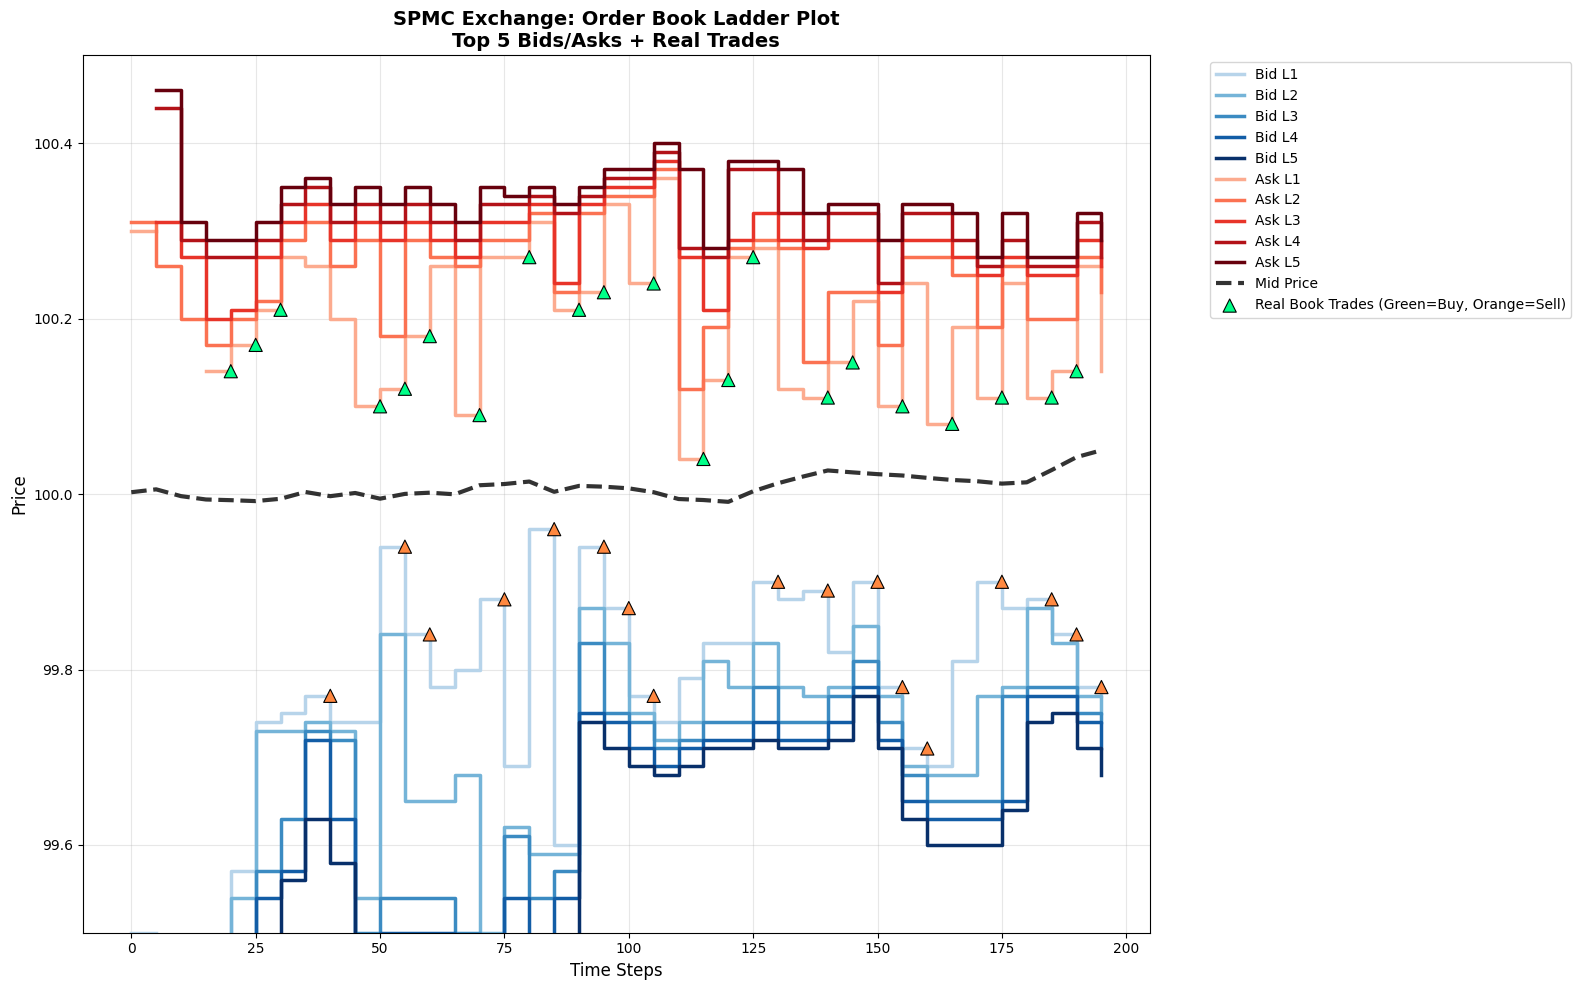

In [ ]:
def plot_ladder(sim, depth: int = 5):
    fig, ax = plt.subplots(figsize=(16, 10))
    times = [s["time"] for s in sim.snapshots]

    # Bid ladders (blue gradient)
    for i in range(depth):
        bid_prices = []
        for s in sim.snapshots:
            if len(s["bids"]) > i and s["bids"][i][0] > 0:
                bid_prices.append(s["bids"][i][0])
            else:
                bid_prices.append(np.nan)
        ax.step(
            times,
            bid_prices,
            where="post",
            label=f"Bid L{i + 1}",
            color=plt.cm.Blues(0.3 + 0.7 * (i / 4)),
            linewidth=2.5,
        )

    # Ask ladders (red gradient)
    for i in range(depth):
        ask_prices = []
        for s in sim.snapshots:
            if len(s["asks"]) > i and s["asks"][i][0] > 0:
                ask_prices.append(s["asks"][i][0])
            else:
                ask_prices.append(np.nan)
        ax.step(
            times,
            ask_prices,
            where="post",
            label=f"Ask L{i + 1}",
            color=plt.cm.Reds(0.3 + 0.7 * (i / 4)),
            linewidth=2.5,
        )

    # Mid prices
    mids = [s["mid"] for s in sim.snapshots if s["mid"] > 0]
    mid_times = times[: len(mids)]
    ax.plot(mid_times, mids, "k--", alpha=0.8, linewidth=3, label="Mid Price")

    # Detect trades based on bid/ask changes
    trade_events = []
    for i in range(1, len(sim.snapshots)):
        prev_bid = (
            sim.snapshots[i - 1]["bids"][0][0]
            if len(sim.snapshots[i - 1]["bids"]) > 0
            and sim.snapshots[i - 1]["bids"][0][0] > 0
            else None
        )
        curr_bid = (
            sim.snapshots[i]["bids"][0][0]
            if len(sim.snapshots[i]["bids"]) > 0 and sim.snapshots[i]["bids"][0][0] > 0
            else None
        )
        prev_ask = (
            sim.snapshots[i - 1]["asks"][0][0]
            if len(sim.snapshots[i - 1]["asks"]) > 0
            and sim.snapshots[i - 1]["asks"][0][0] > 0
            else None
        )
        curr_ask = (
            sim.snapshots[i]["asks"][0][0]
            if len(sim.snapshots[i]["asks"]) > 0 and sim.snapshots[i]["asks"][0][0] > 0
            else None
        )

        # Seller-initiated: market sell
        if prev_bid and curr_bid and prev_bid > curr_bid + 0.005:
            trade_events.append(
                (sim.snapshots[i]["time"], prev_bid, -1)
            )  # Orange trade at hit bid

        # Buyer-initiated: market buy
        if prev_ask and curr_ask and curr_ask > prev_ask + 0.005:
            trade_events.append(
                (sim.snapshots[i]["time"], prev_ask, 1)
            )  # Green trade at hit ask

    # Plot trades
    if trade_events:
        t_times, t_prices, t_sides = zip(*trade_events, strict=True)
        colors = ["#00ff88" if s > 0 else "#ff8840" for s in t_sides]
        sizes = [60 + 30 * abs(s) for s in t_sides]
        ax.scatter(
            t_times,
            t_prices,
            c=colors,
            marker="^",
            s=sizes,
            edgecolors="black",
            linewidth=0.8,
            label="Real Book Trades (Green=Buy, Orange=Sell)",
            zorder=10,
        )

    ax.set_ylim(99.5, 100.5)
    ax.set_xlabel("Time Steps", fontsize=12)
    ax.set_ylabel("Price", fontsize=12)
    ax.set_title(
        f"SPMC Exchange: Order Book Ladder Plot\nTop {depth} Bids/Asks + Real Trades",
        fontsize=14,
        fontweight="bold",
    )
    ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    plot_ladder(sim)